In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


[0.20734967 0.7173321  0.71224016 ... 0.07153315 0.0738315  0.07717939]


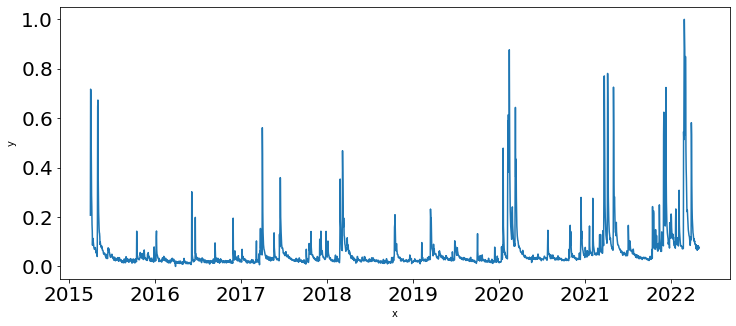

In [266]:
# Prepare DATA
RED_obs = pd.read_csv("RED_Observed.csv")
RED_BOM = pd.read_csv("RED_Rainfall.csv")

# Set date as index and convert to datetime
RED_obs.set_index('Date',inplace=True)
RED_obs.index = pd.to_datetime(RED_obs.index, infer_datetime_format=True).astype('datetime64[ns]')

# Convert columns to numbers
RED_obs['Rainfall'] = pd.to_numeric(RED_obs['Rainfall'], errors='coerce')
RED_obs['Inflow'] = pd.to_numeric(RED_obs['Inflow'], errors='coerce')
RED_obs['Inflow'].fillna(method='ffill', inplace=True)

# Convert date columns to a single datetime and set as index then remove the leftover columns
RED_BOM['Date'] = pd.to_datetime(RED_BOM[['Year','Month','Day']])
RED_BOM.set_index('Date',inplace=True)
RED_BOM.drop(['Year','Month','Day', 'Period over which rainfall was measured (days)', 'Quality'], axis=1, inplace=True)

RED_BOM.rename(columns = {'Rainfall amount (millimetres)': 'Rainfall'},inplace=True)
RED_BOM.dropna(inplace=True)

# Combine the RED_BOM and RED_obs into one df

df = RED_obs.join(RED_BOM, lsuffix='_obs', rsuffix='_BOM') # Left Join on RED_obs
df['Rainfall_BOM'].fillna(method='ffill', inplace=True)
df.dropna(inplace=True)


# Create generic x, y from flows 
dates = df.index.values
N = len(df['Inflow'])
x = df.index.values
y = df['Inflow'].values.astype(np.float32)

# normalise y
y = (y- min(y))/(max(y)-min(y))

print(y)

plt.figure(figsize=(12,5))
plt.xlabel("x")
plt.ylabel("y")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(x, y)

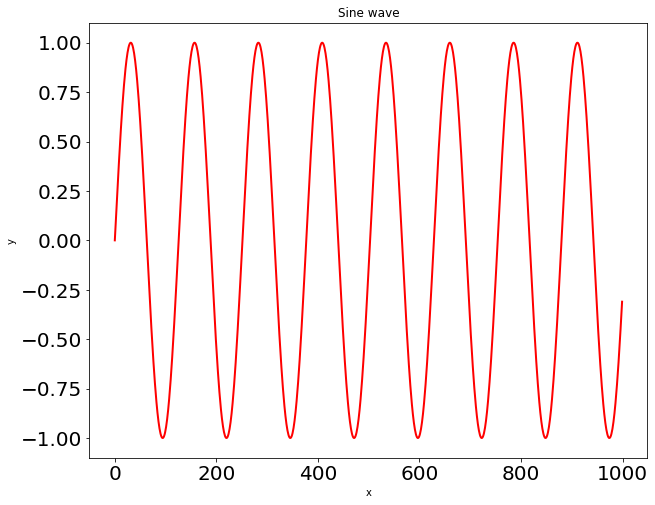

In [234]:
# Generate some easy data for testing the model training works

N = 1
L = 1000
T = 20


x = np.empty(L, np.float32)
x = np.array(range(L))
x = np.array(range(L))
y = np.sin(x/1.0/T).astype(np.float32)

plt.figure(figsize = (10,8))
plt.title("Sine wave")
plt.xlabel("x")
plt.ylabel("y")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(np.arange(x.shape[0]), y[:],'r', linewidth=2.0)
plt.show()

In [229]:
# Convert data set to tensors (LSTMCell)
num_train = 365 # How many training samples to use
num_test = 100 # How many training samples to use

train_data = y[:num_train]
train_target = y[1:num_train+1]

test_data = y[num_train:num_train+num_test]
test_target = y[num_train+1:num_train+num_test+1]

train_input = torch.tensor(train_data)
test_input = torch.tensor(test_data)

train_target = torch.tensor(train_target)
test_target = torch.tensor(test_target)

print(train_input.shape)


torch.Size([365])


In [283]:
print(2575*(1-0.8))
print(2575*(0.2))
print(int(2575*(1-0.8)))
print(int(1-0.8))

514.9999999999999
515.0
514
0


In [287]:
# Convert data set to tensors (LSTM)
split_frac = 0.8

num_train = round(split_frac * len(y))# How many training samples to use
num_test = round((1-split_frac) * len(y)) # How many training samples to use

train_data = y[:num_train]
train_target = y[1:num_train+1]

test_data = y[num_train:num_train+num_test]
test_target = y[num_train+1:num_train+num_test+1]

train_input = torch.tensor(train_data).unsqueeze(-1)
test_input = torch.tensor(test_data).unsqueeze(-1)

train_target = torch.tensor(train_target).unsqueeze(-1)
test_target = torch.tensor(test_target).unsqueeze(-1)

print(num_train, num_test, len(y))

2060 515 2575


In [160]:
# LSTM Class

class LSTMPredictor(nn.Module):
    def __init__(self, n_hidden=51):
        super(LSTMPredictor, self).__init__()

        self.n_hidden = n_hidden
        
        # lstm1, lstm2, linear
        self.lstm1 = nn.LSTMCell(1, self.n_hidden)
        self.lstm2 = nn.LSTMCell(self.n_hidden, self.n_hidden)
        self.linear = nn.Linear(self.n_hidden, 1)

    def forward(self, x, future=0):
        outputs = []

        # Initialize hidden and cell states
        h_t = torch.zeros(self.n_hidden, dtype=torch.float32)
        c_t = torch.zeros(self.n_hidden, dtype=torch.float32)
        h_t2 = torch.zeros(self.n_hidden, dtype=torch.float32)
        c_t2 = torch.zeros(self.n_hidden, dtype=torch.float32)

        # Propagate input through LSTM
        for input_t in x.split(1, dim=0):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        
        # Propogate input through LSTM for future values
        for i in range(future):
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        
        # Convert list to tensor
        outputs = torch.cat(outputs, dim=0)
        return outputs



In [232]:
# LSTM Class 2

class LSTMPredictor2(nn.Module):
    def __init__(self, input_dim=1, n_layers=2, hidden_dim=51):
        super(LSTMPredictor2, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.input_dim = input_dim
        
        # stacked lstm, linear
        self.lstm = nn.LSTM(1, self.hidden_dim, self.n_layers)
        self.Linear = nn.Linear(self.hidden_dim, 1)


    def forward(self, x, future=0):
        outputs = []

        # Initialize hidden and cell states
        h0 = torch.zeros(self.n_layers, self.hidden_dim)
        c0 = torch.zeros(self.n_layers, self.hidden_dim)
        
        # Propagate input through LSTM
        for input_t in x.split(1, dim=0):
            lstm_out, (h0, c0) = self.lstm(input_t, (h0, c0))
            output = self.Linear(lstm_out)
            outputs.append(output)

        # Propogate input through LSTM for future values
        for i in range(future):
            lstm_out, (h0, c0) = self.lstm(output, (h0, c0))
            output = self.Linear(lstm_out)
            outputs.append(output)

        outputs = torch.cat(outputs, dim=0)
        return outputs

        

In [288]:
# Initialize model
model = LSTMPredictor()
model = LSTMPredictor2(input_dim=1, n_layers=10, hidden_dim=64)
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.LBFGS(model.parameters(), lr=0.8)
test_losses = {}

In [263]:
# Training loop

epochs = 4000
for i in range(epochs):
    print("Epoch", i+1)

    # Train model
    def closure():
        optimizer.zero_grad()
        outputs = model(train_input)
        loss = criterion(outputs, train_target)
        print("loss", loss.item())
        loss.backward()
        return loss

    optimizer.step(closure)

    # Evaluate model
    with torch.no_grad():
        future = 365
        pred = model(test_input, future=future)
        loss = criterion(pred[:-future], test_target)
        print("test loss", loss.item())
        y = pred.detach().numpy()
    
    test_losses[i] = loss.item()

    if i==0 or (i+1) % 100 == 0:
        # Plot the prediction
        plt.figure(figsize=(12,5))
        plt.title(f"Step: {i+1}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)

        n = train_input.shape[0] # 2475
        ntest = test_input.shape[0] # 100
        future = 365

        # Draw original data
        plt.plot(np.arange(n), train_input, 'r', linewidth=2.0)
        plt.plot(np.arange(n, n + ntest), test_input, 'b', linewidth=2.0)
        plt.plot(np.arange(n, n + ntest + future), y, 'g', linewidth=2.0)
        plt.savefig(f"images/step{i+1}.png")
        plt.close()

Epoch 1001
loss 0.0006500988965854049
test loss 0.012326368130743504
Epoch 1002
loss 0.0006668965215794742
test loss 0.012366930022835732
Epoch 1003
loss 0.0006977896555326879
test loss 0.012178163975477219
Epoch 1004
loss 0.0006634927703998983
test loss 0.012250076979398727
Epoch 1005
loss 0.0005905373254790902
test loss 0.012403624132275581
Epoch 1006
loss 0.0006561204208992422
test loss 0.012229309417307377
Epoch 1007
loss 0.0006423716549761593
test loss 0.012684171088039875
Epoch 1008
loss 0.000763816584367305
test loss 0.01225382648408413
Epoch 1009
loss 0.0006201062933541834
test loss 0.012098634615540504
Epoch 1010
loss 0.0006473290268331766
test loss 0.012475021183490753
Epoch 1011
loss 0.0006710987654514611
test loss 0.012223665602505207
Epoch 1012
loss 0.0005647410871461034
test loss 0.012312852777540684
Epoch 1013
loss 0.0005833245813846588
test loss 0.012757783755660057
Epoch 1014
loss 0.00062508974224329
test loss 0.012264563702046871
Epoch 1015
loss 0.0006190401036292315


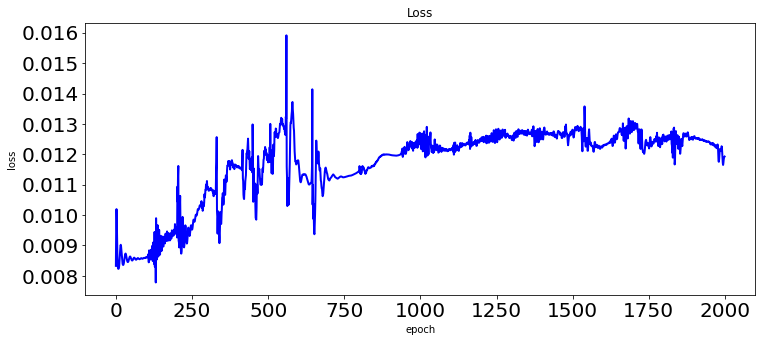

In [264]:
losses = pd.DataFrame([test_losses]).T
losses.columns = ["test"]

plt.figure(figsize=(12,5))
plt.title("Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(losses.index, losses["test"], 'b', linewidth=2.0)

In [111]:
losses.head(20)

,train,test
0,4.197306e+08,3.778084e+08
1,3.778084e+08,3.770497e+08
2,3.770497e+08,3.789884e+08
3,3.789884e+08,2.637453e+08
4,2.637453e+08,4.787233e+08
5,4.787233e+08,3.794217e+08
6,3.794217e+08,3.789352e+08
7,3.789352e+08,1.546358e+09
8,1.546358e+09,3.672537e+09
9,3.672537e+09,3.360882e+10
